In [1]:
cd ..

/home/mars/src_aiai


In [2]:
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.visualisation import compare

In [3]:
from src.operators.NUFFT2D import NUFFT2D
# from src.operators.NURADON import NUFFT2D

from src.sampling.uv_sampling import random_sampling, spider_sampling

In [4]:
import sparse

In [5]:
from src.operators.measurement import calculate_kaiser_bessel_coef_1d


In [6]:
from skimage.metrics import structural_similarity, peak_signal_noise_ratio, mean_squared_error

In [7]:
def compare_single(images, ncols=None, nrows=None, titles=None, same_scale=False, colorbar=False, cmap='viridis', save_base="./plots/example", PSNR=True):
    """[summary]
    TODO add colorbars
    Args:
        images ([type]): [description]
        ncols ([type], optional): [description]. Defaults to None.
        nrows ([type], optional): [description]. Defaults to None.
        titles ([type], optional): [description]. Defaults to None.
        same_scale (bool, optional): [description]. Defaults to False.
    """

    if not nrows:
        nrows = 1
    if not ncols:
        ncols = 1
    if ncols*nrows < len(images):
        ncols = len(images)
        nrows = 1
    if not titles:
        titles = [""]*len(images)

    for i in range(len(images)):
        plt.figure(figsize=(6,6))
        if i == 0:
            a = plt.imshow(images[0], cmap = cmap)    
            vmin, vmax = a.get_clim()
        elif same_scale:
            im = plt.imshow(images[i], vmin=vmin, vmax=vmax, cmap=cmap)
        else:
            im = plt.imshow(images[i], cmap=cmap)
        if i != 0 and PSNR:
            plt.title(titles[i] + f" (PSNR: {peak_signal_noise_ratio(images[0], images[i]):.2f}dB)" ) 
        else:
            plt.title(titles[i])
        if colorbar:
            plt.colorbar(fraction=0.046, pad=0.04)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.savefig(save_base + f"_{titles[i].split(' ')[0]}{i}.pdf", transparent=True)
        plt.show()

In [8]:
class NUFFT_op_1D():
    """NUFFT implementation using a Kaiser-Bessel kernel for interpolation. 

    TODO integrate this function with its 2d variant
    """
    def __init__(self):
        pass
        # TODO generalise more, (pick axes, norm, etc.)
        
    def plan(self, uv, Nd, Kd, Jd, batch_size=None):
        # saving some values
        self.Nd = Nd
        self.Kd = Kd
        self.Jd = Jd
        self.M = len(uv)
        
        if uv.ndim < 2:
            uv = uv[:,np.newaxis]
        
        gridsize = 2*np.pi / Kd[0]
        k = (uv + np.pi) / gridsize
        print(k.shape)
        # calculating coefficients for interpolation
        indices = []
        values =  []
        for i in tqdm.tqdm(range(len(uv))):
            ind, vals = calculate_kaiser_bessel_coef_1d(k[i], i, Jd)
            indices.append(ind)
            values.append(vals.real)
        
        # building sparse matrix
        indices = np.array(indices).reshape(-1, uv.shape[1] +2)
        values = np.array(values).reshape(-1)
        self.interp_matrix = sparse.COO(indices.T, values, shape=[1, len(uv)] + list(Kd) )

        # calculating scaling based on iFT of the KB kernel
        J = Jd[0] 
        beta = 2.34*J
        s_kb = lambda x: np.sinc(np.sqrt((np.pi *x *J)**2 - (2.34*J)**2 +0j)/np.pi)

        # scaling done for both axes seperately
        xx = (np.arange(Kd[0])/Kd[0] -.5)[Kd[0]//4:-Kd[0]//4]
        sa = s_kb(xx).real
        self.scaling = sa # (sa.reshape(-1,1) * sa.reshape(1,-1))
    
    def dir_op(self, xx):
        return np.squeeze(self._kk2k(self._xx2kk(self._pad((xx/self.scaling).reshape(-1, self.Nd[0])))))  # why divide on both sides?

    
    def adj_op(self, k):
        kk = self._k2kk(k)
        xx = self._kk2xx(kk)
        xx = self._unpad(xx)
        xx = np.squeeze(xx) / self.scaling
        return xx
        # return np.squeeze(self._unpad(self._kk2xx(self._k2kk(k)))) / self.scaling
    
    def _kk2k(self, kk):
        """interpolates of the grid to non uniform measurements"""
        return (self.interp_matrix * kk.reshape(-1, 1, self.Kd[0])).sum(axis=(2)).todense()
    
    def _k2kk(self, y):
        """convolutes measurements to oversampled fft grid"""
        return (self.interp_matrix * y.reshape(-1, self.M, 1)).sum(axis=1).todense()
    
    @staticmethod
    def _kk2xx(kk):
        """from 2d fourier space to 2d image space"""
        return np.fft.ifftshift(np.fft.ifft(np.fft.ifftshift(kk, axes=(-1)), norm='ortho'), axes=(-1))

    @staticmethod
    def _xx2kk(xx):
        """from 2d fourier space to 2d image space"""
        return np.fft.fftshift(np.fft.fft(np.fft.fftshift(xx, axes=(-1)), norm='ortho'), axes=(-1))
    
    def _pad(self, x):
        """pads x to go from Nd to Kd"""
        return np.pad(x, (
            ( 0,0 ),
            ( (self.Kd[0]-self.Nd[0])//2, (self.Kd[0]-self.Nd[0])//2),
            ))
    
    
    def _unpad(self, x):
        """unpads x to go from  Kd to Nd"""
        return x[
            :,
            (self.Kd[0]-self.Nd[0])//2: (self.Kd[0]-self.Nd[0])//2 +self.Nd[0],
            ] # remove zero padding from image

In [9]:
from scipy.fft import fft, ifft, fftfreq, fftshift
from functools import partial
from scipy.interpolate import interp1d


In [14]:
class NURADON():
    def __init__(self):
        pass
    
    def plan(self, uv, n_spokes, Nd, Kd, Jd, batch_size=None):
        """uv is of 1 spoke"""
        self.Nd = Nd
        self.Kd = Kd
        self.nufft_1d = NUFFT_op_1D()
        self.nufft_1d.plan(uv, Nd[:1], Kd[:1], Jd[:1], batch_size=None)
        self.n_spokes = n_spokes
    
    
    def dir_op(self, x):
        
        rad = radon(x, theta=np.linspace(0, 360, self.n_spokes, endpoint=False), circle=False, preserve_range=False)# N, M
        x_spokes = self.nufft_1d.dir_op(rad.T) # takes M, N
        return x_spokes /np.sqrt(x_spokes.shape[1])

    def adj_op(self, y):
        x_spokes = self.nufft_1d.adj_op(y)
        print(x_spokes.dtype)
        rec = iradon(x_spokes.T.real, theta=np.linspace(0, 360, self.n_spokes, endpoint=False), circle=False, preserve_range=True, filter_name=None, output_size=self.Nd[0])   
        print(rec.dtype)
        return rec / (np.pi / (2 * self.n_spokes)) / np.sqrt(2*self.Nd[0])
    
    
    def alt_adj_op(self, y, circle=False):
        theta = np.linspace(0, 360, self.n_spokes, endpoint=False)     
        radon_filtered =  np.real( self.nufft_1d.adj_op(y.reshape(n_spokes, -1)).T)

        reconstructed = np.zeros((self.Nd[0], self.Nd[1]), dtype=np.complex128)
        radius = self.Nd[0] // 2
        xpr, ypr = np.mgrid[:self.Nd[0], :self.Nd[0]] - radius
        x = np.arange(self.Nd[0]) - self.Nd[0] // 2

        for col, angle in zip(radon_filtered.T, np.deg2rad(theta)):
            t = ypr * np.cos(angle) - xpr * np.sin(angle)
            interpolant = partial(np.interp, xp=x, fp=col, left=0, right=0)
            reconstructed += interpolant(t)

        if circle:
            out_reconstruction_circle = (xpr ** 2 + ypr ** 2) > radius ** 2
            reconstructed[out_reconstruction_circle] = 0.

        return reconstructed / np.sqrt(2*self.Nd[0]) 

In [15]:
from skimage.transform import radon, iradon

In [16]:
wavebands = np.linspace(500,900, 10) # probably need to do something slightly diffferent
object_distance = 250 #km
lenslet_diameter = 8.75 #mm
longest_baseline = 0.5 #m
n_lenslets = 24
n_PICs = 37
n_specbins = 10

uvs = spider_sampling(normalised=False)

In [17]:
x0 = 0.15
pic = x0 + np.linspace(0,0.5, n_lenslets).reshape(-1,1)
angles = np.linspace(0,2*np.pi, n_PICs, endpoint=False)

coords = np.array([ (pic*np.cos(angles).reshape(1,-1)).flatten(), (pic*np.sin(angles).reshape(1,-1)).flatten()]).T

In [18]:
sns.set_context('paper', font_scale=1.6)

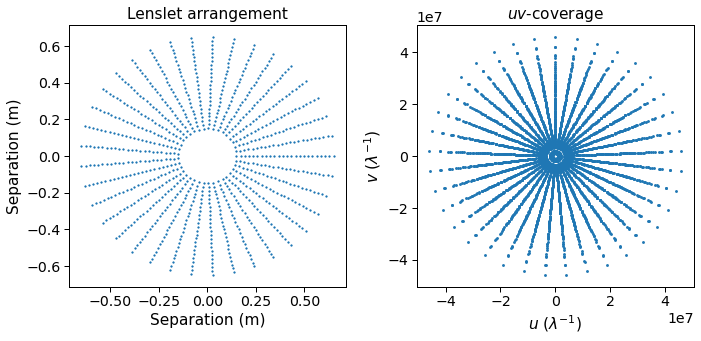

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].scatter(coords[:,0], coords[:,1], s=2)
ax[0].set_xlabel('Separation (m)')
ax[0].set_ylabel('Separation (m)')
ax[0].set_title('Lenslet arrangement')


ax[1].scatter(uvs[:,0], uvs[:,1], s=4)
ax[1].set_xlabel(r'$u$ $(\lambda^{-1})$')
ax[1].set_ylabel(r'$v$ $(\lambda^{-1})$')
ax[1].set_title(r'$uv$-coverage')


plt.tight_layout()
plt.savefig("./plots/spider_config.pdf", transparent = True)
# plt.subplots_adjust(wspace=0.2)

In [20]:
im = np.load("./data/intermediate/TNG/NUFFT_SPIDER/x_true_test_30dB.npy")

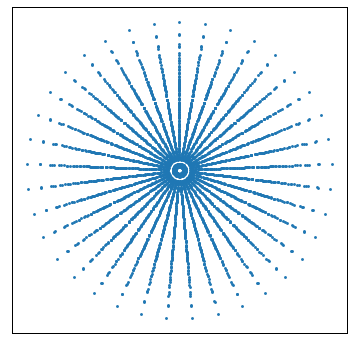

In [21]:
plt.figure(figsize=(6,6))
plt.scatter(uvs[:,0], uvs[:,1], s=4)
plt.xticks([])
plt.yticks([])
plt.savefig("./plots/presentation_diagram_4.pdf")

In [22]:
uv = spider_sampling()

In [23]:
def dft(x, w, m):
    
    return np.array([np.sum(m * np.exp(1j*w*i)) for i in x ])/(2*len(x))

def dft2(x1, x2, w, m):
   
    w1 = np.exp(1j * w[:,0])
    w2 = np.exp(1j * w[:,1])
    N = len(x1)
    res = np.zeros((len(x1), len(x2)))
    for i in tqdm.tqdm(range(len(x1))):
        for j in range(len(x2)):
            res[i,j] = np.sum( w1**(x1[i]) * w2**(x2[j]) *m)
    return res/(2*len(x1))

In [24]:
from src.data import load_M51

In [25]:
x = load_M51()
x /= x.max()

x2 = np.load("./data/intermediate/COCO/NUFFT_SPIDER/x_true_test_30dB.npy")[4]
x2 /= x2.max()

x = x2

In [26]:
Nd = x.shape
Kd = (x.shape[0]*2, x.shape[1]*2)
Jd = (6,6)
batch_size = 1

In [27]:
n_spokes = 37
n_lenslets = 24
n_wavelengths = 10

In [28]:
uv = spider_sampling()
# uv = random_sampling(Nd[0]**2//4)
nufft_op = NUFFT2D()
nufft_op.plan(uv, Nd, Kd, Jd, batch_size)

100%|██████████| 4440/4440 [00:00<00:00, 5011.01it/s]


In [29]:
true = np.load(f"./data/intermediate/COCO/NUFFT_SPIDER/x_true_test_30dB.npy")


In [30]:


op_1d = NUFFT_op_1D()
uv_1d = uv[:n_lenslets//2*n_wavelengths,1] # 1 spoke has 120 measurements
# uv_1d = np.concatenate((-uv[:120,1][::-1], uv[:120,1]))
op_1d.plan(uv_1d.reshape(-1,1), [Nd[0]], [Kd[0]], [6])

(120, 1)


100%|██████████| 120/120 [00:00<00:00, 3696.24it/s]


In [31]:
y2 = nufft_op.dir_op(x2)
y = nufft_op.dir_op(x)

In [32]:
x_dirty_dft = dft2(np.arange(-x.shape[0]//2,x.shape[0]//2), np.arange(-x.shape[0]//2,x.shape[0]//2), uv, y.reshape(-1))

  0%|          | 0/256 [00:00<?, ?it/s]/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
100%|██████████| 256/256 [01:14<00:00,  3.45it/s]


In [34]:
xx, yy = np.mgrid[:Nd[0],:Nd[0]]
circle_mask = ((xx-Nd[0]//2)**2 + (yy-Nd[0]//2)**2 < (Nd[0]//2-2)**2 ) #* ((xx-Nd[0]//2)**2 + (yy-Nd[0]//2)**2 < Nd[0]//2**2 )

In [35]:
def forward(x):
    rad = radon(x, theta=np.linspace(0,360,n_spokes, endpoint=False), circle=True, preserve_range=False)# N, M
    x_spokes = op_1d.dir_op(rad.T) # takes M, N
    return rad, x_spokes /np.sqrt(x_spokes.shape[1])

def adjoint(y, filter_name='ramp'):
    x_spokes = op_1d.adj_op(y)
    print(x_spokes.dtype)
    rec = iradon(x_spokes.T.real, theta=np.linspace(0,360,n_spokes, endpoint=False), circle=True, preserve_range=False, filter_name=filter_name, output_size=Nd[0])   
    print(rec.dtype)
    return x_spokes, rec / (np.pi / (2 * n_spokes)) / np.sqrt(2*Nd[0])

In [36]:
nuradon_op  = NURADON()
nuradon_op.plan(uv_1d, n_spokes, Nd, Kd, Jd)

(120, 1)


100%|██████████| 120/120 [00:00<00:00, 14230.84it/s]


In [154]:
x_dirty_nufft = nufft_op.adj_op(y).real
x_dirty_radon = nuradon_op.adj_op(y.reshape(-1, n_lenslets//2*n_wavelengths))[::-1,::1].real
x_dirty_radon2 = nuradon_op.alt_adj_op(y.reshape(-1, n_lenslets//2*n_wavelengths))[::-1,::1].real

complex128
float64


In [124]:
rms = lambda x,y:  np.mean(np.square((x-y))*circle_mask)

In [125]:
Nd[0]*Nd[1]/nufft_op.n_measurements

14.76036036036036

In [126]:
x_dirty_dft

array([[-0.26838717, -0.26677955, -0.27526337, ...,  0.14333466,
         0.13501038,  0.10695165],
       [-0.27486332, -0.26845984, -0.27393599, ...,  0.13989052,
         0.13152612,  0.10203243],
       [-0.27975867, -0.26962872, -0.27347191, ...,  0.13559481,
         0.12335085,  0.0916481 ],
       ...,
       [ 0.12128563,  0.16892453,  0.19956736, ..., -0.08363494,
        -0.10791343, -0.15432609],
       [ 0.08313107,  0.1229973 ,  0.15003641, ..., -0.0987943 ,
        -0.11798868, -0.15779678],
       [ 0.04218106,  0.07495374,  0.09922506, ..., -0.11585245,
        -0.12966398, -0.16095267]])

In [127]:
ISNR = 30
sigma = np.sqrt(np.mean(np.abs(y)**2)) * 10**(-ISNR/20)
n = np.random.normal( 0, sigma, y.shape) + 1j * np.random.normal( 0, sigma, y.shape)

In [157]:
yf = nuradon_op.dir_op(x)

/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/skimage/transform/radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


In [158]:
xdr3 = nuradon_op.adj_op(yf)

complex128
float64


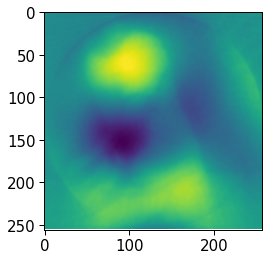

In [159]:
plt.imshow(xdr3)

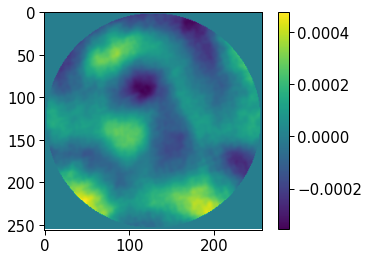

In [155]:
plt.imshow((x_dirty_nufft-x_dirty_dft)*circle_mask)
plt.colorbar()

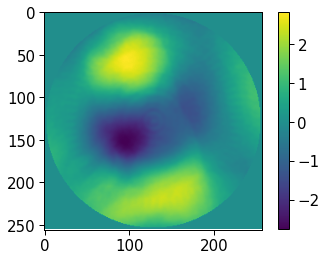

In [160]:
plt.imshow((xdr3-x_dirty_dft)*circle_mask)
plt.colorbar()

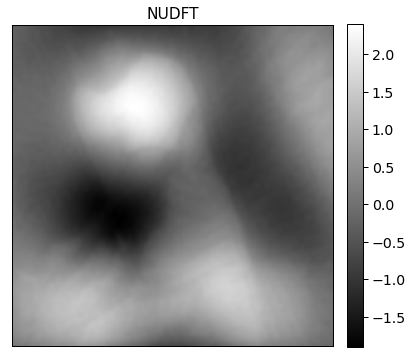

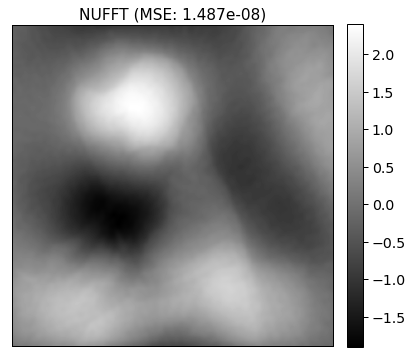

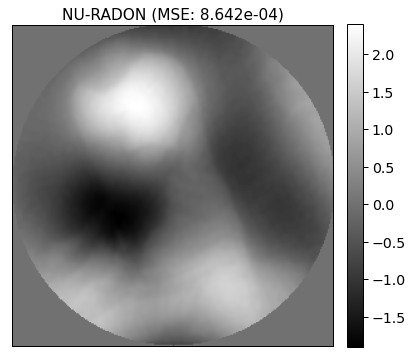

In [109]:
compare_single([x_dirty_dft, x_dirty_nufft, x_dirty_radon], titles=["NUDFT", f"NUFFT (MSE: {rms(x_dirty_dft, x_dirty_nufft):.3e})", f"NU-RADON (MSE: {rms(x_dirty_radon,x_dirty_dft):.3e})"], PSNR=False, same_scale=True, colorbar=True, save_base="./plots/self_adjoint", cmap='gray')

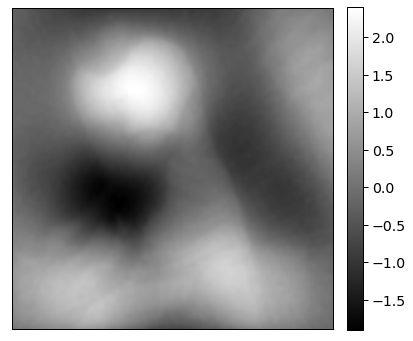

ValueError: im_true has intensity values outside the range expected for its data type.  Please manually specify the data_range

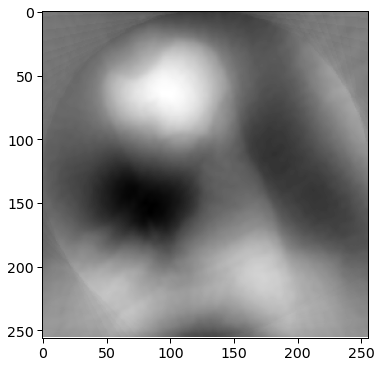

In [130]:
compare_single([x_dirty_nufft, x_dirty_radon],  same_scale=False, colorbar=True, save_base="./plots/self_adjoint", cmap='gray')

In [131]:
def compare_multiple(images, ncols=None, nrows=None, titles=None, same_scale=False, colorbar=False, cmap='viridis', save_base="./plots/example", PSNR=True):
    """[summary]
    TODO add colorbars
    Args:
        images ([type]): [description]
        ncols ([type], optional): [description]. Defaults to None.
        nrows ([type], optional): [description]. Defaults to None.
        titles ([type], optional): [description]. Defaults to None.
        same_scale (bool, optional): [description]. Defaults to False.
    """

    if not nrows:
        nrows = 1
    if not ncols:
        ncols = 1
    if ncols*nrows < len(images):
        ncols = len(images)
        nrows = 1
    if not titles:
        titles = [""]*len(images)
    
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, 
        figsize=(ncols*6, nrows*6), squeeze=False)

    a = ax[0,0].imshow(images[0])    
    ax[0,0].set_title(titles[0])
    vmin, vmax = a.get_clim()
    for i in range(0, nrows):
        for j in range(ncols):
            if i +j*nrows >= len(images):
                break
            if same_scale:
                im = ax[i,j].imshow(images[j + i*ncols], 
                    vmin=vmin, vmax=vmax, cmap=cmap)
            else:
                im = ax[i,j].imshow(images[j + i*ncols], cmap=cmap)
            ax[i,j].set_title(titles[j + i*ncols])

  
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
    if colorbar:
        plt.colorbar(im, ax=ax, anchor=(1.2,0))
    plt.subplots_adjust(wspace=.01)

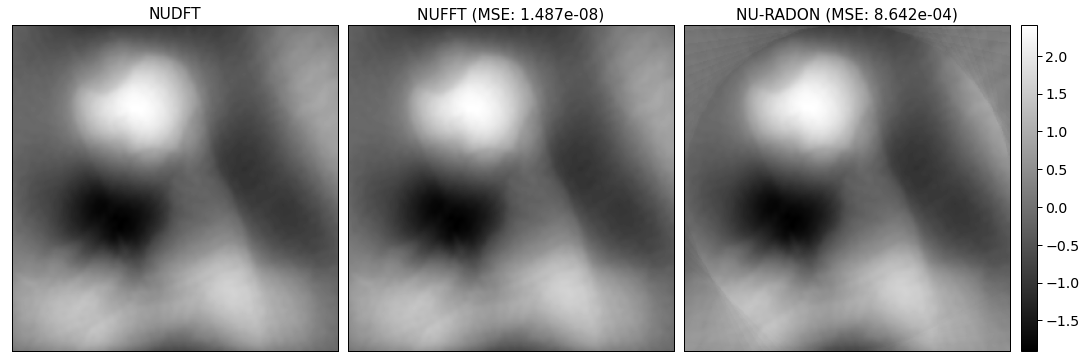

In [132]:
sns.set_context('paper', font_scale=1.6)
compare_multiple([x_dirty_dft, x_dirty_nufft, x_dirty_radon], titles=["NUDFT", f"NUFFT (MSE: {rms(x_dirty_dft, x_dirty_nufft):.3e})", f"NU-RADON (MSE: {rms(x_dirty_radon,x_dirty_dft):.3e})"],  same_scale=True, colorbar=True, save_base="./plots/self_adjoint", cmap='gray')
plt.savefig("./plots/self_adjoint_all.pdf")

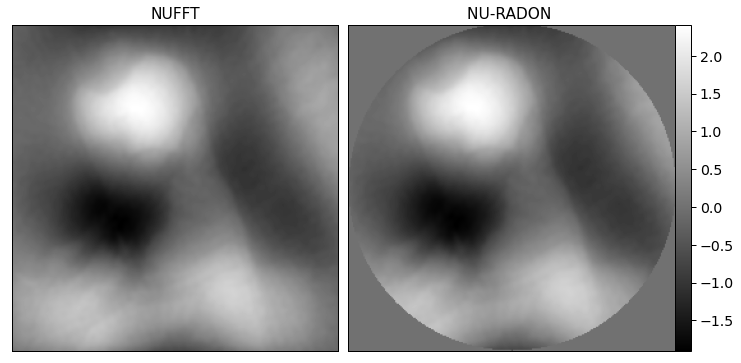

In [46]:
compare_multiple([x_dirty_nufft, x_dirty_radon], titles=[ f"NUFFT" , f"NU-RADON "],  same_scale=True, colorbar=True, save_base="./plots/self_adjoint", cmap='gray')


In [133]:


# sampling density based weighting
grid_cell = 2*np.pi /512 
binned = (uv[:,:]+np.pi+.5*grid_cell) // grid_cell
binned = [tuple(x) for x in binned]
cells = set(binned)
w_gridded = np.zeros(uv.shape[0])
for cell in list(cells):
    mask = np.all(np.array(cell) ==  binned, axis=1)
    w_gridded[mask] = np.sum(mask)

# w = 
w2 = 1/w_gridded
w2 /= w2.max()

In [134]:
# sampling density based weighting
grid_cell = 2*np.pi /512 
binned = (uv[:,:]+np.pi+.5*grid_cell) // grid_cell
binned = [tuple(x) for x in binned]
cells = set(binned)
w_gridded = np.zeros(uv.shape[0])
for cell in list(cells):
    mask = np.all(np.array(cell) ==  binned, axis=1)
    w_gridded[mask] = np.sum(mask)

# w = 
w2 = 1/w_gridded
w2 /= w2.max()

In [135]:
binned = (uv[:120,1] + np.pi+.5*grid_cell) // grid_cell
# binned = [tuple(x) for x in binned]
cells = set(binned)
w_gridded = np.zeros(120)
for cell in list(cells):
    mask = np.array(cell) ==  binned
    w_gridded[mask] = np.sum(mask)

# w = 
w_1d = 1/w_gridded

w_1d = np.tile(w_1d, n_spokes)
# w_1d /= w_1d.max()

In [136]:
w = np.linalg.norm(uv, axis=1)


In [137]:
w = np.linalg.norm(uv, axis=1)
w /= w.max()
# x_dirty_dft_ramp = dft2(np.arange(-x.shape[0]//2,x.shape[0]//2), np.arange(-x.shape[0]//2,x.shape[0]//2), uv, y.reshape(-1) * w2)

In [138]:
x_dirty_nufft_ramp = nufft_op.adj_op(y*w*w_1d).real #(np.linalg.norm(w) / np.linalg.norm(np.ones_like(w)))

x_dirty_nufft_dens = nufft_op.adj_op(y*w2).real #(np.linalg.norm(w) / np.linalg.norm(np.ones_like(w)))
# x_dirty_radon_ramp = nuradon_op.adj_op((y*w2).reshape(-1, n_lenslets//2*n_wavelengths))[::-1,::1]

In [139]:
# x_dirty_nufft = (x_dirty_nufft - x_dirty_nufft.min())/(x_dirty_nufft = (x_dirty_nufft.max() - x_dirty_nufft.min())
# x_dirty_nufft_ramp = (x_dirty_nufft_ramp - x_dirty_nufft_ramp.min())/(x_dirty_nufft_ramp = (x_dirty_nufft_ramp.max() - x_dirty_nufft_ramp.min())                                                                      

In [140]:
def compare_multiple(images, ncols=None, nrows=None, titles=None, same_scale=False, colorbar=False, cmap='viridis', save_base="./plots/example", cbar_anchor=1.2, rot=0, vmin=None, vmax=None, PSNR=True):
    """[summary]
    TODO add colorbars
    Args:
        images ([type]): [description]
        ncols ([type], optional): [description]. Defaults to None.
        nrows ([type], optional): [description]. Defaults to None.
        titles ([type], optional): [description]. Defaults to None.
        same_scale (bool, optional): [description]. Defaults to False.
    """

    if not nrows:
        nrows = 1
    if not ncols:
        ncols = 1
    if ncols*nrows < len(images):
        ncols = len(images)
        nrows = 1
    if not titles:
        titles = [""]*len(images)
    
    images = [np.rot90(i, rot) for i in images]
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, 
        figsize=(ncols*6, nrows*6), squeeze=False)

    a = ax[0,0].imshow(images[0])    
    ax[0,0].set_title(titles[0])
    if vmin is None:
        vmin, vmax = a.get_clim()
    for i in range(0, nrows):
        for j in range(ncols):
            if i +j*nrows >= len(images):
                break
            if same_scale:
                im = ax[i,j].imshow(images[j + i*ncols], 
                    vmin=vmin, vmax=vmax, cmap=cmap)
            else:
                im = ax[i,j].imshow(images[j + i*ncols], cmap=cmap)
            if j % ncols != 0 and PSNR:
                if titles[j + i*ncols]:
                    ax[i,j].set_title(titles[j + i*ncols] + f"\n(PSNR: {peak_signal_noise_ratio(images[i*ncols], images[j + i*ncols]):.2f}dB)" ) 
                else:
                    ax[i,j].set_title(f"(PSNR: {peak_signal_noise_ratio(images[i*ncols], images[j + i*ncols]):.2f}dB)" ) 
                    
            else:
                if titles[j + i*ncols]:
                    ax[i,j].set_title(titles[j + i*ncols] +"\n"*PSNR)
                else:
                    ax[i,j].set_title(titles[j + i*ncols])
                    
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
    if colorbar:
        plt.colorbar(im, ax=ax, anchor=(cbar_anchor,0))
    plt.subplots_adjust(wspace=.01)

In [146]:
structural_similarity(x, x_dirty_nufft), structural_similarity(x, x_dirty_radon)

/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  """Entry point for launching an IPython kernel.


(-0.0035930063147839135, 0.026395352260022154)

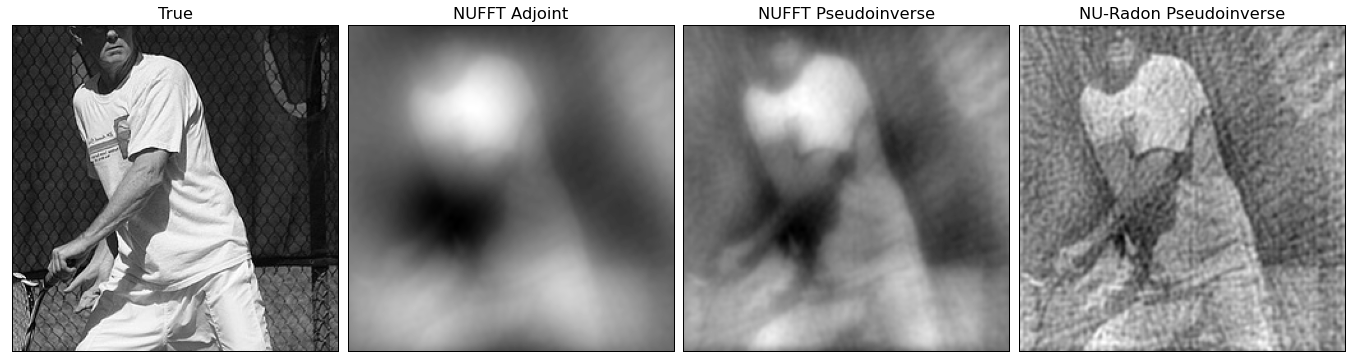

In [148]:
sns.set_context('paper', font_scale=1.7)
compare_multiple([x, x_dirty_nufft, x_dirty_nufft_dens, x_dirty_nufft_ramp], titles=["True", f"NUFFT Adjoint", f"NUFFT Pseudoinverse", f"NU-Radon Pseudoinverse"],  same_scale=False, colorbar=False, cmap='gray', PSNR=False)
plt.savefig("./plots/nufft_filtering.pdf")

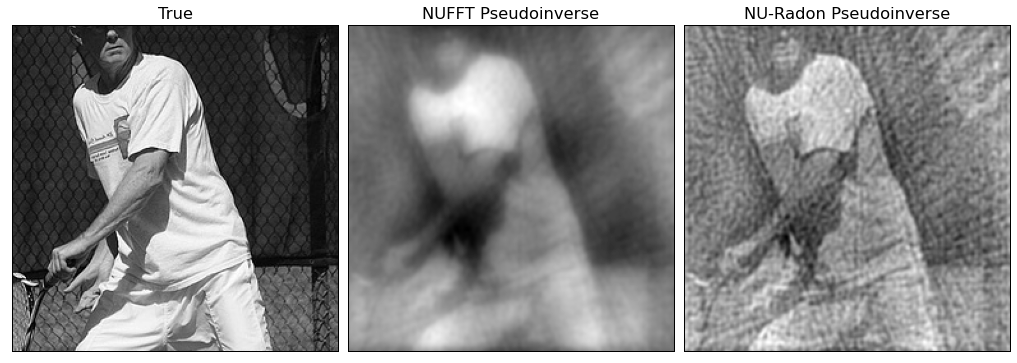

In [150]:
sns.set_context('paper', font_scale=1.7)
compare_multiple([x, x_dirty_nufft_dens, x_dirty_nufft_ramp], titles=["True", f"NUFFT Pseudoinverse", f"NU-Radon Pseudoinverse"],  same_scale=False, colorbar=False, cmap='gray', PSNR=False)
plt.savefig("./plots/nufft_filtering2.pdf")

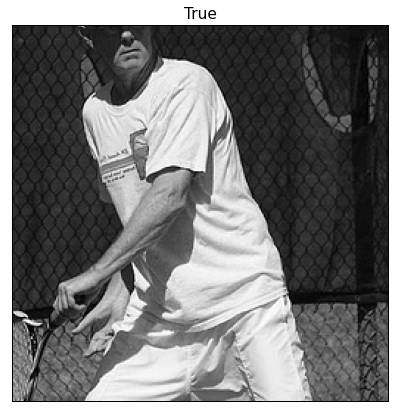

/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


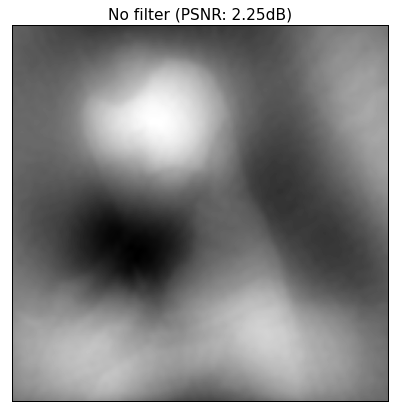

/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


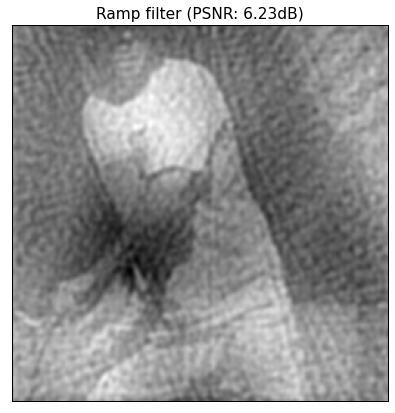

/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


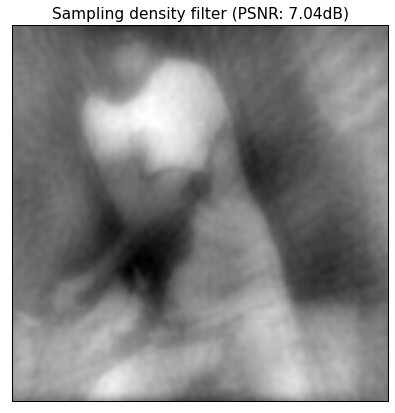

In [103]:

compare_single([x, x_dirty_nufft, x_dirty_nufft_ramp, x_dirty_nufft_dens], titles=["True", f"No filter", f"Ramp filter", f"Sampling density filter"],  same_scale=False, colorbar=False, save_base="./plots/nufft", cmap='gray')

In [31]:
import time

In [32]:
def timeis(func):
    '''Decorator that reports the execution time.'''
  
    def wrap(*args, **kwargs):
        l = []
        for i in range(100):
            start = time.perf_counter()
            result = func(*args, **kwargs)
            end = time.perf_counter()
            l.append(end-start)
        print(f"{func.__name__:<20} & ${np.mean(l)*1e3:.3f} \pm {np.std(l)*1e3:.3f}$ \\\\")
        return result
    return wrap


In [33]:
@timeis
def batch_nufft(n=10):
    return nufft_op.adj_op(y).real

@timeis
def batch_nuradon(n=10):
    return nuradon_op.alt_adj_op(y).real

In [34]:
n = 100
a = batch_nufft(n)
a = batch_nuradon(n)

batch_nufft          & $80.799 \pm 5.100$ \\
batch_nuradon        & $59.805 \pm 1.937$ \\


In [35]:
@timeis
def batch_nufft(n=10):
    return nufft_op.dir_op(x)

@timeis
def batch_nuradon(n=10):
    return nuradon_op.dir_op(x)

In [36]:
a = batch_nufft(n)
a = batch_nuradon(n)

batch_nufft          & $53.264 \pm 2.224$ \\


/home/mars/.local/lib/python3.9/site-packages/skimage/transform/radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


batch_nuradon        & $101.225 \pm 2.394$ \\


In [37]:
8.496744498988846 / n, 6.308662931987783/n

(0.08496744498988847, 0.06308662931987782)

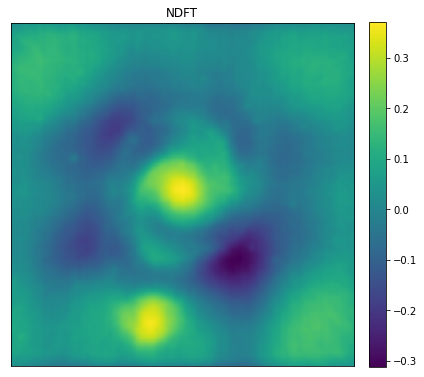

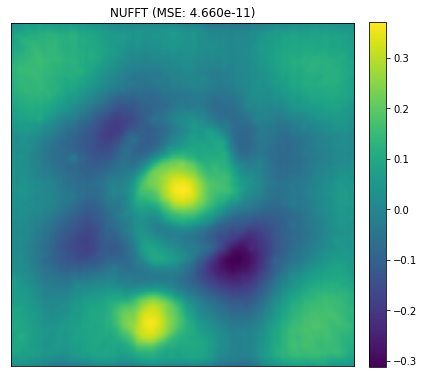

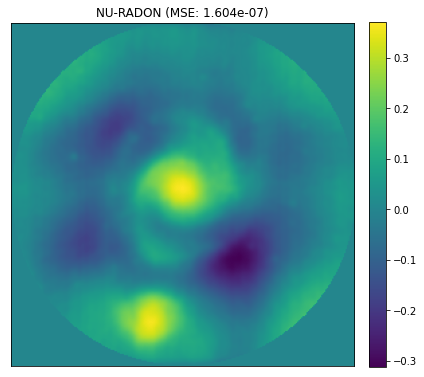

In [38]:
compare_single([x_dirty_dft_ramp, x_dirty_nufft_ramp, x_dirty_radon_ramp], titles=["NDFT", f"NUFFT (MSE: {rms(x_dirty_dft_ramp, x_dirty_nufft_ramp):.3e})", f"NU-RADON (MSE: {rms(x_dirty_radon_ramp,x_dirty_dft_ramp):.3e})"],  same_scale=True, colorbar=True, save_base="./plots/filtered_self_adjoint")

In [145]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

In [39]:
 x_scaled_ramp = (x_dirty_nufft_ramp - x_dirty_nufft_ramp.min())/ (x_dirty_nufft_ramp.max() - x_dirty_nufft_ramp.min())

In [45]:
peak_signal_noise_ratio(x, x_dirty_nufft), peak_signal_noise_ratio(x, x_dirty_nufft_ramp), peak_signal_noise_ratio(x, x_scaled_ramp)

/tmp/ipykernel_459/2804069520.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  peak_signal_noise_ratio(x, x_dirty_nufft), peak_signal_noise_ratio(x, x_dirty_nufft_ramp), peak_signal_noise_ratio(x, x_scaled_ramp)


(6.324285460267563, 8.81109751444437, 12.585799047382434)

In [46]:
structural_similarity(x, x_dirty_nufft), structural_similarity(x, x_dirty_nufft_ramp), structural_similarity(x, x_scaled_ramp)

/tmp/ipykernel_459/464900511.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  structural_similarity(x, x_dirty_nufft), structural_similarity(x, x_dirty_nufft_ramp), structural_similarity(x, x_scaled_ramp)


(0.07459463581844157, 0.09061824941453446, 0.7696484509144079)

In [69]:
np.linalg.norm(w)/np.linalg.norm(np.ones_like(w))

0.45311216481513905

In [121]:
x_dirty_nufft_dens.min()

-1.2968660941941794

In [123]:
x_dirty_nufft_dens = nufft_op.adj_op(y*w_quad).real #(np.linalg.norm(w) / np.linalg.norm(np.ones_like(w)))


/tmp/ipykernel_94971/1480771462.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  compare([x, x_dirty_nufft, x_dirty_nufft_ramp, x_dirty_nufft_dens], titles=["dft", f"{peak_signal_noise_ratio(x, x_dirty_nufft):.3f}", f"{peak_signal_noise_ratio(x, x_dirty_nufft_ramp):.3f}", f"{rms(x_dirty_nufft_dens,x):.3f}"],  same_scale=False, colorbar=True)


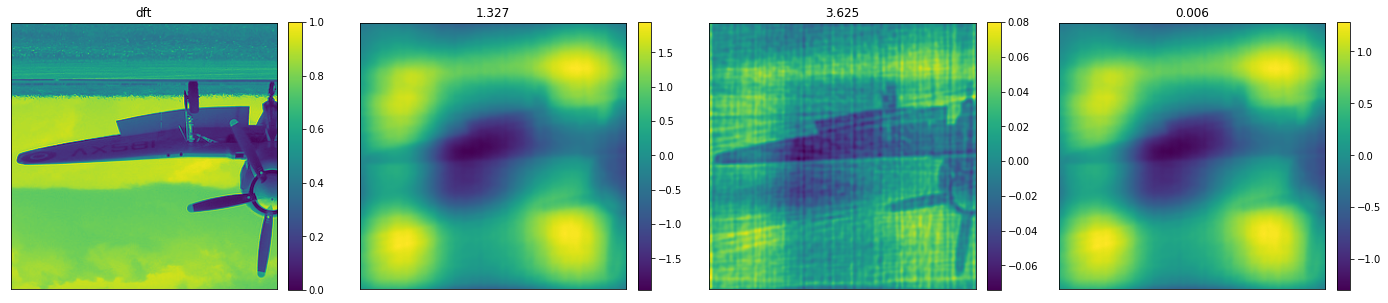

In [127]:
compare([x, x_dirty_nufft, x_dirty_nufft_ramp, x_dirty_nufft_dens], titles=["dft", f"{peak_signal_noise_ratio(x, x_dirty_nufft):.3f}", f"{peak_signal_noise_ratio(x, x_dirty_nufft_ramp):.3f}", f"{rms(x_dirty_nufft_dens,x):.3f}"],  same_scale=False, colorbar=True)

/tmp/ipykernel_94971/2068075908.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  compare([x, x_dirty_nufft, x_dirty_nufft_ramp, x_dirty_nufft_dens], titles=["dft", f"{structural_similarity(x, x_dirty_nufft):.3f}", f"{structural_similarity(x, x_dirty_nufft_ramp):.3f}", f"{structural_similarity(x_dirty_nufft_dens,x):.3f}"],  same_scale=False, colorbar=True)


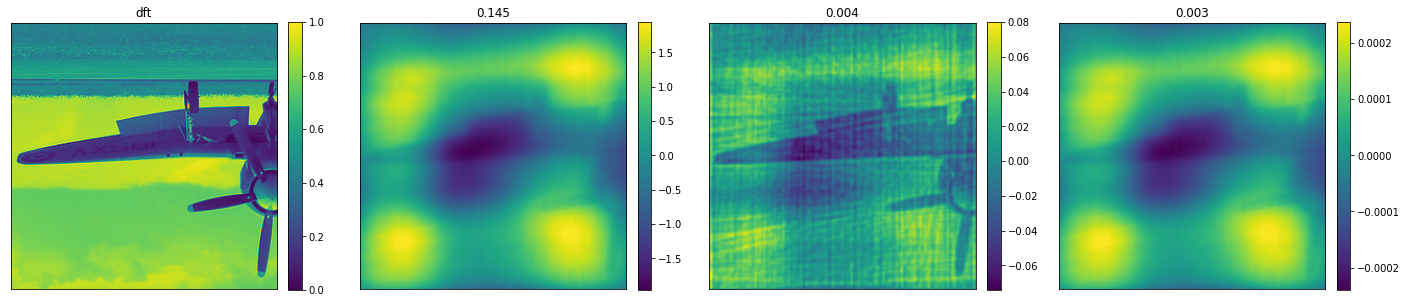

In [98]:
compare([x, x_dirty_nufft, x_dirty_nufft_ramp, x_dirty_nufft_dens], titles=["dft", f"{structural_similarity(x, x_dirty_nufft):.3f}", f"{structural_similarity(x, x_dirty_nufft_ramp):.3f}", f"{structural_similarity(x_dirty_nufft_dens,x):.3f}"],  same_scale=False, colorbar=True)

In [ ]:
##### x_scaled_ramp = (x_dirty_nufft_ramp - x_dirty_nufft_ramp.min())/ (x_dirty_nufft_ramp.max() - x_dirty_nufft_ramp.min())
x_scaled_dens = (x_dirty_nufft_dens - x_dirty_nufft_dens.min())/ (x_dirty_nufft_dens.max() - x_dirty_nufft_dens.min())

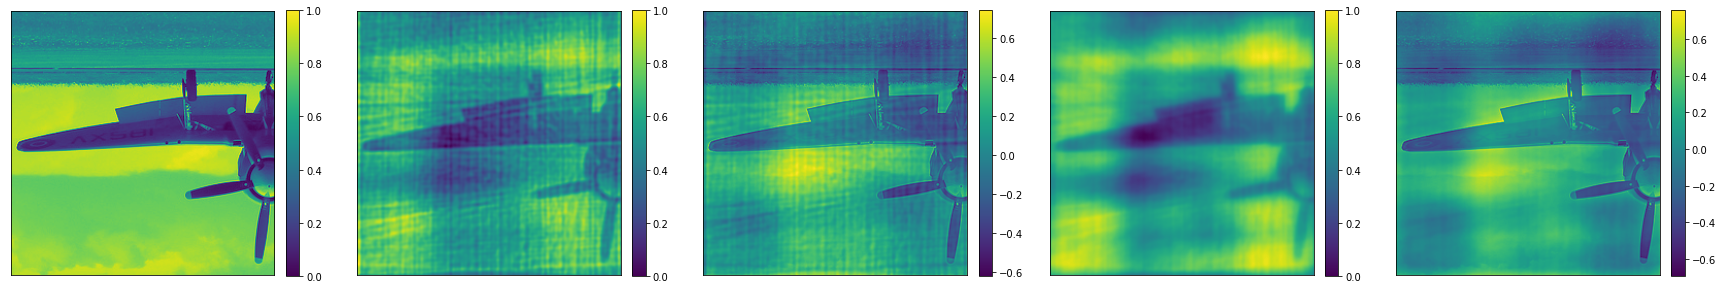

In [52]:
compare([x, x_scaled_ramp, x-x_scaled_ramp, x_scaled_dens, x - x_scaled_dens], same_scale =False, colorbar=True)

In [38]:
from scipy.optimize import minimize

In [73]:
mn = minimize(lambda a: -1* structural_similarity(x, x_dirty_nufft_dens * a[0] + a[1]), np.array([1,0]))

/tmp/ipykernel_94971/876650426.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  mn = minimize(lambda a: -1* structural_similarity(x, x_dirty_nufft_dens * a[0] + a[1]), np.array([1,0]))


In [74]:
mn

      fun: -0.6936471820474299
 hess_inv: array([[ 7.40402476, -1.13802622],
       [-1.13802622,  0.98381885]])
      jac: array([-2.13831663e-06, -1.74343586e-06])
  message: 'Optimization terminated successfully.'
     nfev: 39
      nit: 9
     njev: 13
   status: 0
  success: True
        x: array([0.48025583, 0.6001855 ])

In [75]:
x_dirty_nufft_ramp2 = nufft_op.adj_op(y2*w).real #(np.linalg.norm(w) / np.linalg.norm(np.ones_like(w)))

In [81]:
mn = minimize(lambda a: -1* peak_signal_noise_ratio(x, x_dirty_nufft_dens * a[0] + a[1]), np.array([1,0]))

/tmp/ipykernel_94971/308980374.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  mn = minimize(lambda a: -1* peak_signal_noise_ratio(x, x_dirty_nufft_dens * a[0] + a[1]), np.array([1,0]))


In [82]:
mn

      fun: -12.684986683741105
 hess_inv: array([[ 0.21043472, -0.01611829],
       [-0.01611829,  0.00744224]])
      jac: array([ 1.66893005e-06, -1.19209290e-06])
  message: 'Optimization terminated successfully.'
     nfev: 33
      nit: 6
     njev: 11
   status: 0
  success: True
        x: array([0.71408743, 0.56536104])

In [363]:
Nd[0]**2/ nufft_op.n_measurements

4.0

In [366]:
f = lambda a: peak_signal_noise_ratio(x, x_dirty_nufft_ramp * a[0] + a[1])

In [367]:
x_dirty_nufft_ramp.min(), x_dirty_nufft_ramp.max()

(-0.7820357794184168, 1.0864395807556602)

In [83]:
x_opt_scaled = x_dirty_nufft_dens * mn.x[0] + mn.x[1]

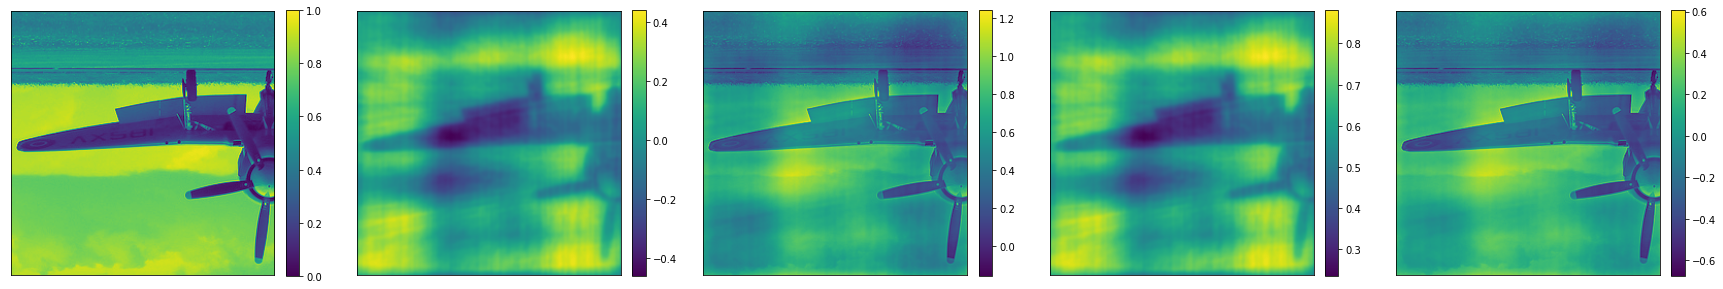

In [84]:
compare([x, x_dirty_nufft_dens, x-x_dirty_nufft_dens, x_opt_scaled, x - x_opt_scaled], same_scale =False, colorbar=True)

In [240]:
peak_signal_noise_ratio(x, x_dirty_nufft_ramp), structural_similarity(x, x_dirty_nufft_ramp)

/tmp/ipykernel_71023/3703854874.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  peak_signal_noise_ratio(x, x_dirty_nufft_ramp), structural_similarity(x, x_dirty_nufft_ramp)
/tmp/ipykernel_71023/3703854874.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  peak_signal_noise_ratio(x, x_dirty_nufft_ramp), structural_similarity(x, x_dirty_nufft_ramp)


(4.821020080558282, 0.11644422904941615)

In [239]:
peak_signal_noise_ratio(x, x_scaled), structural_similarity(x, x_scaled)

/tmp/ipykernel_71023/1875007403.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  peak_signal_noise_ratio(x, x_scaled), structural_similarity(x, x_scaled)
/tmp/ipykernel_71023/1875007403.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  peak_signal_noise_ratio(x, x_scaled), structural_similarity(x, x_scaled)


(12.210250566200507, 0.5851355641548917)

In [108]:
w_quad = np.array([1/(np.sum( np.sinc((k - uv)/np.pi))**2) for k in uv])

In [110]:
w_quad /= w_quad.max()

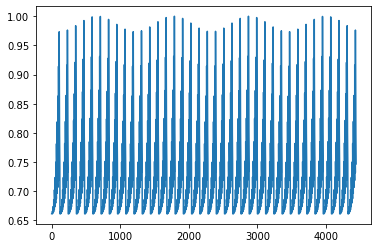

In [111]:
plt.plot(w_quad)

In [41]:
Nd[0]/nufft_op.n_measurements

0.02882882882882883

In [281]:
np.linalg.norm(w), np.linalg.norm(w2),

(30.19237013769158, 49.11065817143716)

In [310]:
1/(Kd[0]/nufft_op.n_measurements)

8.671875

In [319]:
peak_signal_noise_ratio(x, x_dirty_nufft_ramp *8.671875 ), structural_similarity(x, x_dirty_nufft_ramp*8.671875  )

/tmp/ipykernel_119766/2288154846.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  peak_signal_noise_ratio(x, x_dirty_nufft_ramp *8.671875 ), structural_similarity(x, x_dirty_nufft_ramp*8.671875  )
/tmp/ipykernel_119766/2288154846.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  peak_signal_noise_ratio(x, x_dirty_nufft_ramp *8.671875 ), structural_similarity(x, x_dirty_nufft_ramp*8.671875  )


(8.807936533094525, 0.06703164118446972)

In [297]:
peak_signal_noise_ratio(x, x_scaled), structural_similarity(x, x_scaled)

/tmp/ipykernel_119766/1875007403.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  peak_signal_noise_ratio(x, x_scaled), structural_similarity(x, x_scaled)
/tmp/ipykernel_119766/1875007403.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  peak_signal_noise_ratio(x, x_scaled), structural_similarity(x, x_scaled)


(11.928894381688064, 0.7375497521906167)

In [316]:
np.linspace(1, 25, 100)[np.argmax([ peak_signal_noise_ratio(x, x_dirty_nufft_ramp*i) for i in np.linspace(1, 25, 100)])]

/tmp/ipykernel_119766/42545471.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  np.linspace(1, 25, 100)[np.argmax([ peak_signal_noise_ratio(x, x_dirty_nufft_ramp*i) for i in np.linspace(1, 25, 100)])]


8.757575757575758

/tmp/ipykernel_119766/4281353658.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  plt.plot(np.linspace(1, 25, 100), [ peak_signal_noise_ratio(x, x_dirty_nufft_ramp*i) for i in np.linspace(1, 25, 100)])


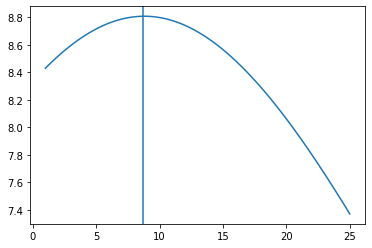

In [317]:
plt.plot(np.linspace(1, 25, 100), [ peak_signal_noise_ratio(x, x_dirty_nufft_ramp*i) for i in np.linspace(1, 25, 100)])
plt.axvline(8.7)

In [263]:
structural_similarity(x, x_dirty_nufft_ramp)

/tmp/ipykernel_119766/2463670779.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  structural_similarity(x, x_dirty_nufft_ramp)


0.012123015638713692

In [110]:
mse = lambda x,y:  np.mean(np.square(np.abs(x-y)))

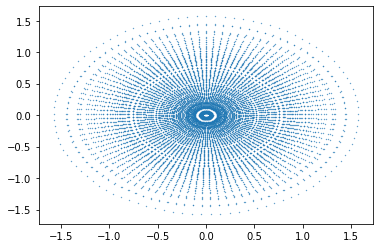

In [605]:
plt.scatter(uv[:,0], uv[:,1], s=.1)

In [187]:
def forward(x):
    x = np.pad(x, (
            ( (Kd[0]-Nd[0])//2, (Kd[0]-Nd[0])//2),
            ( (Kd[0]-Nd[0])//2, (Kd[0]-Nd[0])//2),
            ))
    rad = radon(x, theta=np.linspace(0,360,n_spokes, endpoint=False), circle=True, preserve_range=False)# N, M
    print(rad.shape)
    x_spokes = op_1d.dir_op(rad.T) # takes M, N
    return rad, x_spokes /np.sqrt(x_spokes.shape[1])

In [188]:
rad, x_spokes_f = forward(x)

(128, 111)


In [189]:
x_spokes_f.shape

(111, 120)

In [202]:
b = adjoint(x_spokes_f, filter_name=None)[1]/ (np.pi / (2 * n_spokes)) / np.sqrt(4*Kd[0])

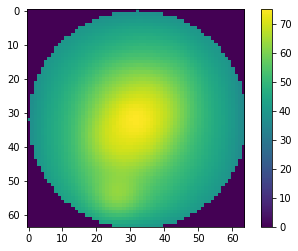

In [203]:
plt.imshow(b)
plt.colorbar()

In [176]:
op_1d.interp_matrix.shape

(1, 120, 128)

In [179]:
Nd, Kd

((64, 64), (128, 128))

In [186]:
rad = radon(x, theta=np.linspace(0,360,n_spokes, endpoint=False), circle=True, preserve_range=False)# N, M
x_spokes_f = op_1d.dir_op(rad.T) # takes M, N
x_spokes_f /= np.sqrt(x_spokes_f.shape[1])

ValueError: operands could not be broadcast together with shapes (111,64) (128,) 

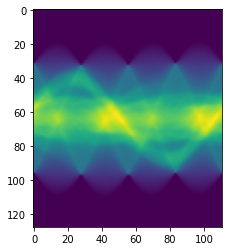

In [181]:
plt.imshow(rad)

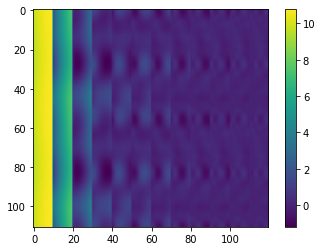

In [204]:
plt.imshow(x_spokes_f.real)
plt.colorbar()

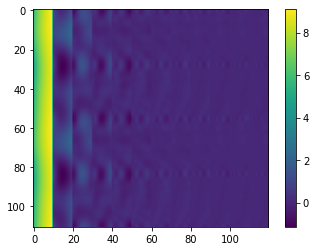

In [205]:
plt.imshow(y.reshape(x_spokes_f.shape).real)
plt.colorbar()

In [206]:
mse(x_spokes_f, y.reshape(x_spokes_f.shape))

2.9345419022876533

In [145]:
x_spokes = op_1d.adj_op(x_spokes_f)

rec = iradon(x_spokes.T.real, theta=np.linspace(0,360,n_spokes, endpoint=False), circle=True, preserve_range=False, filter_name=None, output_size=Nd[0]) / (np.pi / (2 * n_spokes))/ np.sqrt(2*Nd[0])

In [146]:
rec2 = nufft_op.adj_op(x_spokes_f.flatten())[::-1].real

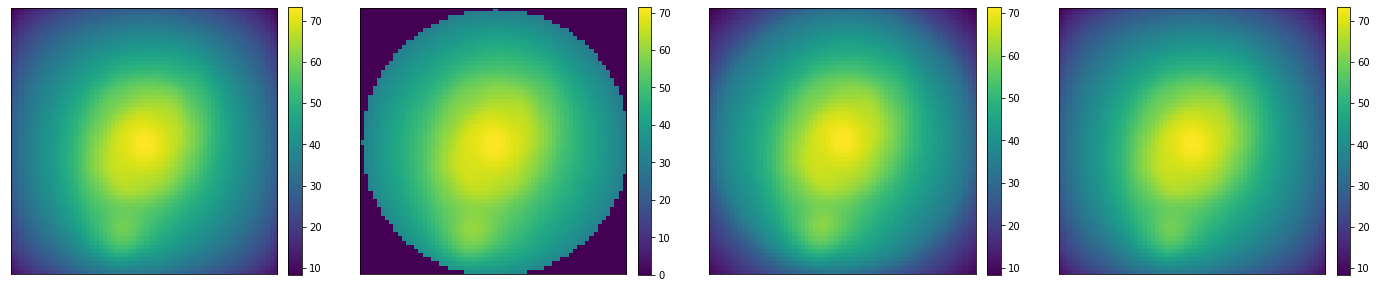

In [148]:
compare([x_dirty_dft, rec, rec2, x_dirty_nufft], same_scale=False, colorbar=True)

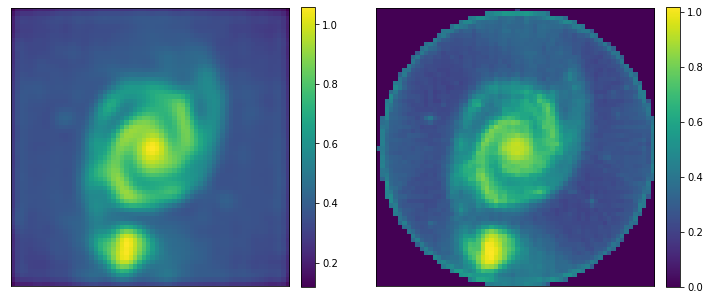

In [82]:
compare([x_dirty_dft_ramp, iradon(rad, theta=np.linspace(0,360,n_spokes, endpoint=False), circle=True, preserve_range=False, filter_name='ramp', output_size=Nd[0])], same_scale=False, colorbar=True)


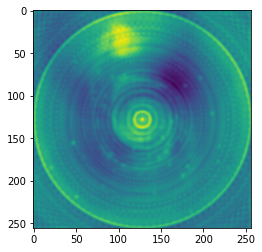

In [633]:
plt.imshow(nufft_op.adj_op(y_radon.flatten()*w).real)

In [577]:
rad, b = op_1d.adj_op(y_nufft.reshape(n_spokes, -1))

/tmp/ipykernel_59428/4287425517.py:1: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(b.real + 1e-10))


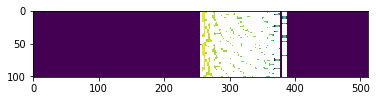

In [578]:
plt.imshow(np.log(b.real + 1e-10))

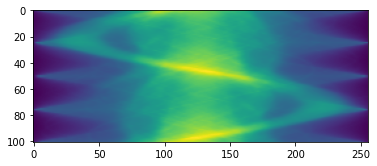

In [579]:
plt.imshow(a.T)

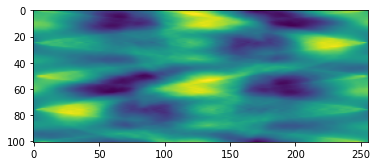

In [580]:
plt.imshow(rad.real)

In [488]:
np.mean(np.abs(y_radon)/np.abs(y_nufft))

115.81446847295506

In [489]:
np.sqrt(2*Nd[0])

22.627416997969522

In [484]:
mse(y_nufft, y_radon.flatten())

9.83302882494181

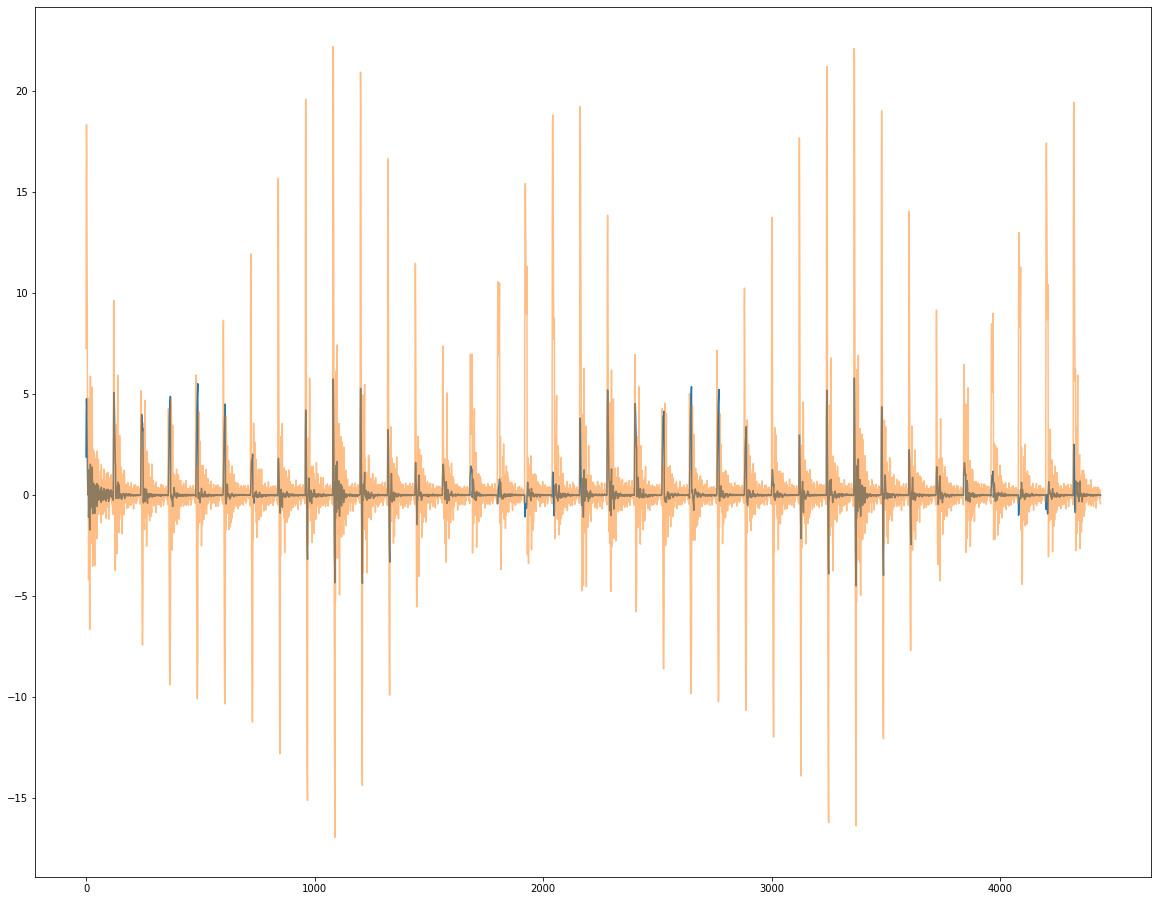

In [485]:
plt.figure(figsize=(20,16))
plt.plot(y_nufft.real)
plt.plot(y_radon.flatten().real, alpha=.5)